# DSP Project
# Ashwin R Nair - 122101004

# **Speech based emotion recognition for stress based applications**

# Importing modules

In [82]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn


In [83]:
dataset_folder_path = '/kaggle/input/all-datasets/Ravdess/audio_speech_actors_01-24'

files = [file for file in os.listdir(dataset_folder_path)]
print("Files in the dataset folder:")
for file in files:
    print(file)

Files in the dataset folder:
Actor_02
Actor_17
Actor_05
Actor_16
Actor_21
Actor_01
Actor_11
Actor_20
Actor_08
Actor_15
Actor_06
Actor_12
Actor_23
Actor_24
Actor_22
Actor_04
Actor_19
Actor_10
Actor_09
Actor_14
Actor_03
Actor_13
Actor_18
Actor_07


# Extracting emotion, gender and stress level from the dataset

In [84]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
DATA_PATH = '/kaggle/input/all-datasets/Ravdess/audio_speech_actors_01-24'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        
        if emotion == 8:
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'Not_Stressed'
        else:
            emotion_intensity = 'Stressed'

        gender_str = identifiers[6].split()[0]
        gender_num = int(gender_str)

        if gender_num % 2 == 0:
            gender = 'female'
        else:
            gender = 'male'

        data = pd.concat([data, pd.DataFrame({"Emotion": [emotion],
                                      "Emotion intensity": [emotion_intensity],
                                      "Gender": [gender],  "Path": [file_path]})],ignore_index=True)

In [85]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Emotion intensity,Gender,Path
0,0,Not_Stressed,female,/kaggle/input/all-datasets/Ravdess/audio_speec...
1,1,Not_Stressed,female,/kaggle/input/all-datasets/Ravdess/audio_speec...
2,7,Stressed,female,/kaggle/input/all-datasets/Ravdess/audio_speec...
3,7,Not_Stressed,female,/kaggle/input/all-datasets/Ravdess/audio_speec...
4,1,Not_Stressed,female,/kaggle/input/all-datasets/Ravdess/audio_speec...


# Load the signals

In [86]:
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 1439/1440 files

# Split the data

In [87]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):]
    ind_test = emotion_ind[int(0.5*m):]
    
    ind_train = np.array(ind_train, dtype=np.int32)
    ind_val = np.array(ind_val, dtype=np.int32)
    ind_test = np.array(ind_test, dtype=np.int32)
    
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
    
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)

Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)

train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

del X

X_train:(1147, 144000), Y_train:(1147,)
X_val:(293, 144000), Y_val:(293,)
X_test:(720, 144000), Y_test:(720,)


# Augment signals by adding White Gaussian Noise

In [88]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal_len = len(signal)
    
    noise = np.random.normal(size=(augmented_num, signal_len))
    
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    target_snr = np.random.randint(snr_low, snr_high)
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K
    return signal + K.T * noise

In [89]:
def generate_augmented_data(X_train, Y_train, batch_size):
    while True:
        indices = np.random.randint(0, len(X_train), batch_size)
        batch_X = X_train[indices]
        batch_Y = Y_train[indices]
        aug_signals = []
        aug_labels = []
        for signal, label in zip(batch_X, batch_Y):
            augmented_signals = addAWGN(signal)
            for aug_signal in augmented_signals:
                aug_signals.append(aug_signal)
                aug_labels.append(label)
        yield np.array(aug_signals), np.array(aug_labels)

batch_size = 32
train_generator = generate_augmented_data(X_train, Y_train, batch_size)

num_batches = len(X_train) // batch_size
for batch_idx in range(num_batches):
    batch_X_aug, batch_Y_aug = next(train_generator)
    print(f"Processed batch {batch_idx + 1}/{num_batches}")

Processed batch 1/35
Processed batch 2/35
Processed batch 3/35
Processed batch 4/35
Processed batch 5/35
Processed batch 6/35
Processed batch 7/35
Processed batch 8/35
Processed batch 9/35
Processed batch 10/35
Processed batch 11/35
Processed batch 12/35
Processed batch 13/35
Processed batch 14/35
Processed batch 15/35
Processed batch 16/35
Processed batch 17/35
Processed batch 18/35
Processed batch 19/35
Processed batch 20/35
Processed batch 21/35
Processed batch 22/35
Processed batch 23/35
Processed batch 24/35
Processed batch 25/35
Processed batch 26/35
Processed batch 27/35
Processed batch 28/35
Processed batch 29/35
Processed batch 30/35
Processed batch 31/35
Processed batch 32/35
Processed batch 33/35
Processed batch 34/35
Processed batch 35/35


# Function to calculate spectrograms

Spectrogram shape:  (128, 563)


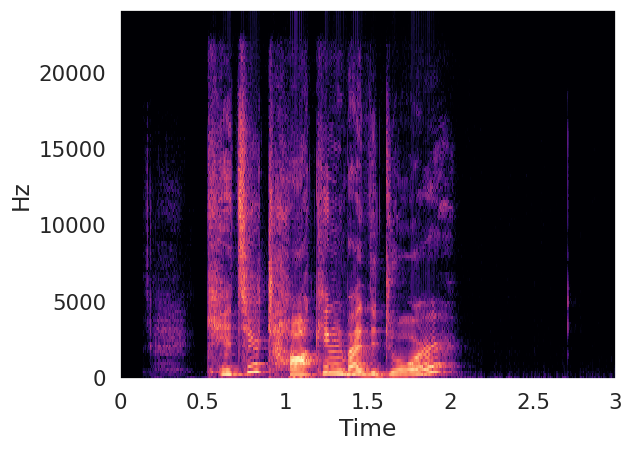

In [90]:
def getSpectrogram(audio, sample_rate):
    
    stft = librosa.stft(y=audio,
                        n_fft=1024,
                        win_length=512,
                        window='hamming',
                        hop_length=256)
    spectrogram = np.abs(stft)
    spectrogram_resized = cv2.resize(spectrogram,(563,128))
    return spectrogram_resized

# Test function
audio, sample_rate = librosa.load(data.loc[0, 'Path'], duration=3, offset=0.5, sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3),))
signal[:len(audio)] = audio
spectrogram = getSpectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=SAMPLE_RATE, hop_length=256, x_axis='time', y_axis='linear')
print('Spectrogram shape: ', spectrogram.shape)


# Calculating Spectrograms for training, validation and testing datasets

In [91]:
spectrogram_train = []
print("Calculatin spectrograms for train set")
for i in range(X_train.shape[0]):
    spectrogram1 = getSpectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    spectrogram_train.append(spectrogram1)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
del X_train

spectrogram_val = []
print("Calculatin spectrograms for val set")
for i in range(X_val.shape[0]):
    spectrogram1 = getSpectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    spectrogram_val.append(spectrogram1)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
del X_val

spectrogram_test = []
print("Calculatin spectrograms for test set")
for i in range(X_test.shape[0]):
    spectrogram1 = getSpectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    spectrogram_test.append(spectrogram1)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
del X_test


Calculatin spectrograms for train set
 Processed 1146/1147 files
Calculatin spectrograms for val set
 Processed 292/293 files
Calculatin spectrograms for test set
 Processed 719/720 files


# Split into chunks

In [92]:
def splitIntoChunks(stft,win_size,stride):
    t = stft.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = stft[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [93]:
spectrogram_train_chunked = []
for stft in spectrogram_train:
    chunks = splitIntoChunks(stft, win_size=128,stride=64)
    spectrogram_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

spectrogram_val_chunked = []
for stft in spectrogram_val:
    chunks = splitIntoChunks(stft, win_size=128,stride=64)
    spectrogram_val_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

spectrogram_test_chunked = []
for stft in spectrogram_test:
    chunks = splitIntoChunks(stft, win_size=128,stride=64)
    spectrogram_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

Number of chunks is 7
Number of chunks is 7
Number of chunks is 7


# Create the model

In [94]:

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        elif len(x.size()) == 3: 
            x_reshape = x.contiguous().view(-1, x.size(2))  
        elif len(x.size()) == 4: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) 
        else:
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) 

        y = self.module(x_reshape)

        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1)) 
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2))
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3))
        return y

In [95]:
class HybridModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=1024,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.4)
        self.attention_linear = nn.Linear(2*hidden_size,1)
        self.out_linear = nn.Linear(2*hidden_size,num_emotions)
        
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),dim=-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding)
        attention = torch.squeeze(attention, 1)
        output_logits = self.out_linear(attention)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax, attention_weights_norm


In [96]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# Function for Model Training

In [97]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        model.train()
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        loss = loss_fnc(output_logits, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

# Function for Model Validation

In [98]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

# Stack data

In [99]:
X_train = np.stack(spectrogram_train_chunked,axis=0)
X_train = np.expand_dims(X_train,2)
print('Shape of X_train: ',X_train.shape)
X_val = np.stack(spectrogram_val_chunked,axis=0)
X_val = np.expand_dims(X_val,2)
print('Shape of X_val: ',X_val.shape)
X_test = np.stack(spectrogram_test_chunked,axis=0)
X_test = np.expand_dims(X_test,2)
print('Shape of X_test: ',X_test.shape)

del spectrogram_train_chunked
del spectrogram_train
del spectrogram_val_chunked
del spectrogram_val
del spectrogram_test_chunked
del spectrogram_test

Shape of X_train:  (1147, 7, 1, 128, 128)
Shape of X_val:  (293, 7, 1, 128, 128)
Shape of X_test:  (720, 7, 1, 128, 128)


# Scale data

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

b,t,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,t,c,h,w))

b,t,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,t,c,h,w))

b,t,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,t,c,h,w))

# Train the model

In [101]:
EPOCHS=200
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()))
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")


Selected device is cuda
Number of trainable params:  582761
 Epoch 0: iteration 34/35
Epoch 0 --> loss:1.9857, acc:15.61%, val_loss:1.9622, val_acc:23.55%
 Epoch 1: iteration 34/35
Epoch 1 --> loss:1.8857, acc:24.85%, val_loss:1.9114, val_acc:23.89%
 Epoch 2: iteration 34/35
Epoch 2 --> loss:1.8242, acc:24.76%, val_loss:1.8833, val_acc:25.60%
 Epoch 3: iteration 34/35
Epoch 3 --> loss:1.7883, acc:26.68%, val_loss:1.8770, val_acc:27.30%
 Epoch 4: iteration 34/35
Epoch 4 --> loss:1.7905, acc:26.50%, val_loss:1.8654, val_acc:27.65%
 Epoch 5: iteration 34/35
Epoch 5 --> loss:1.7756, acc:28.16%, val_loss:1.8545, val_acc:26.96%
 Epoch 6: iteration 34/35
Epoch 6 --> loss:1.7513, acc:27.38%, val_loss:1.8805, val_acc:28.67%
 Epoch 7: iteration 34/35
Epoch 7 --> loss:1.7405, acc:28.77%, val_loss:1.8328, val_acc:31.06%
 Epoch 8: iteration 34/35
Epoch 8 --> loss:1.7378, acc:29.56%, val_loss:1.8341, val_acc:31.40%
 Epoch 9: iteration 34/35
Epoch 9 --> loss:1.7375, acc:30.86%, val_loss:1.8306, val_a

# Save model in PyTorch

In [102]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_attention_lstm_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_attention_lstm_model.pt')))

Model is saved to /kaggle/working/models/cnn_attention_lstm_model.pt


# Load model

In [103]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_attention_lstm_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_attention_lstm_model.pt')))

Model is loaded from /kaggle/working/models/cnn_attention_lstm_model.pt


# Testing the data

In [104]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.787
Test accuracy is 75.97%


# Saving the model in Tensorflow

In [105]:
import os
import torch
from torchvision import models

SAVE_PATH = os.path.join(os.getcwd(), 'models')
os.makedirs(SAVE_PATH, exist_ok=True)

model = models.resnet18()

import h5py
from collections import OrderedDict

state_dict = model.state_dict()
ordered_state_dict = OrderedDict()
for key, value in state_dict.items():
    ordered_state_dict[key] = value.cpu().numpy()  # Convert tensors to numpy arrays

hdf5_path = os.path.join(SAVE_PATH, 'resnet18_model.h5')
with h5py.File(hdf5_path, 'w') as f:
    for key, value in ordered_state_dict.items():
        f.create_dataset(key, data=value)

print('Model is saved to {}'.format(hdf5_path))

Model is saved to /kaggle/working/models/resnet18_model.h5


# Confusion Matrix

Sensitivity:
 [0.80208333 0.5625     0.85416667 0.8125     0.73958333 0.77083333
 0.72916667 0.70833333]
Specificity:
 [0.97115385 0.9702381  0.94391026 0.95032051 0.93589744 0.99679487
 0.97596154 0.98076923]
Accuracy: 0.7597222222222222


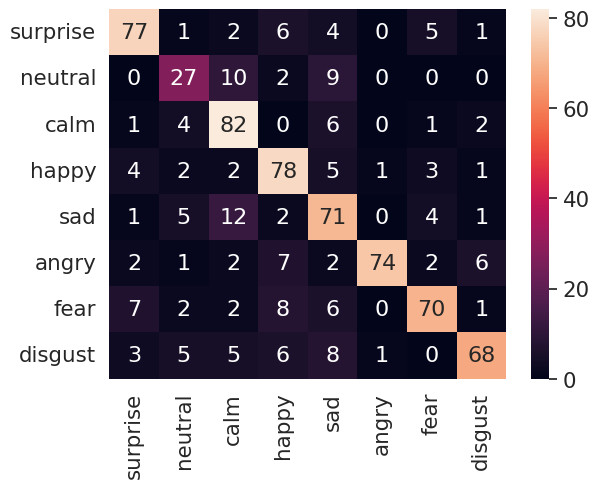

In [110]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

predictions_cpu = predictions.cpu().numpy()
num_emotions = len(EMOTIONS)

cm = confusion_matrix(Y_test, predictions_cpu, labels=range(num_emotions))
names = [EMOTIONS[ind] for ind in range(num_emotions)]
df_cm = pd.DataFrame(cm, index=names, columns=names)

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = accuracy_score(Y_test, predictions_cpu)

print("Sensitivity:\n", sensitivity)
print("Specificity:\n", specificity)
print("Accuracy:", accuracy)

sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
plt.show()


# Calculate overall sensitivity, specificity, and accuracy


In [111]:
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_accuracy = accuracy_score(Y_test, predictions_cpu)

print("Overall Sensitivity (Recall):", overall_sensitivity)
print("Overall Specificity:", overall_specificity)
print("Overall Accuracy:", overall_accuracy)


Overall Sensitivity (Recall): 0.7473958333333334
Overall Specificity: 0.9656307234432234
Overall Accuracy: 0.7597222222222222


# Correlation between Stressed and Not stressed

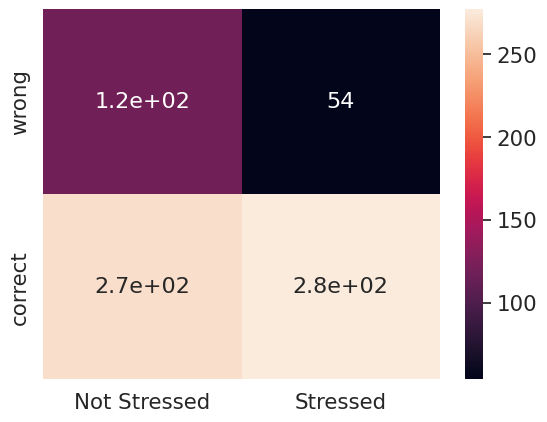

In [113]:
correct_Not_Stressed = 0
correct_Stressed = 0
wrong_Not_Stressed = 0
wrong_Stressed = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'Not_Stressed':
            correct_Not_Stressed += 1
        else:
            correct_Stressed += 1
    else: # wrong prediction
        if intensity == 'Not_Stressed':
            wrong_Not_Stressed += 1
        else:
            wrong_Stressed += 1
array = np.array([[wrong_Not_Stressed,wrong_Stressed],[correct_Not_Stressed,correct_Stressed]])
df = pd.DataFrame(array,['wrong','correct'],['Not Stressed','Stressed'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plotting Training and Validation losses

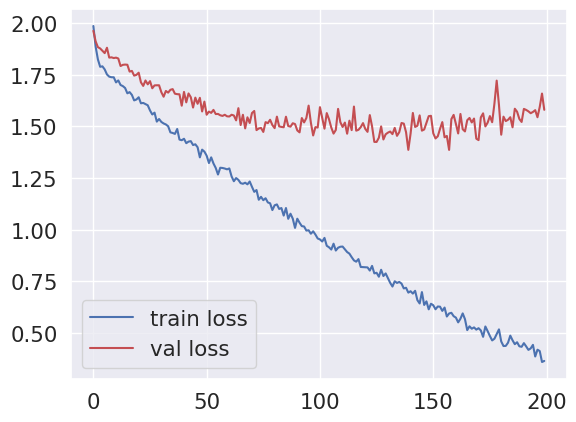

In [114]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])